Popular Models for Transfer Learning:


*   ResNet (Residual Networks)
*   InceptionNet
*   MobileNet (lightweight CNN for mobile and embedded devices)
*   VGGNet
*   EfficientNet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Mounted at /content/drive


In [2]:
# Define paths to dataset directories
train_dir = '/content/drive/My Drive/Data/GTSRB/Train/GTSRB/Final_Training/Images/'
test_dir = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/'

# Define image size for resizing
IMG_SIZE = 32  # Resize images to 32x32

# Helper function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    # Loop through each subdirectory (which corresponds to a class)
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)

        if os.path.isdir(label_path):
            label = int(label_dir)  # Subdirectory name is the class label

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Check if the file has a valid image extension
                _, file_extension = os.path.splitext(img_file)
                if file_extension.lower() not in valid_extensions:
                    print(f"Skipping non-image file: {img_file}")
                    continue  # Skip non-image files (e.g., CSV)

                # Read the image using OpenCV
                image = cv2.imread(img_path)

                # Resize image
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Append the image and label to the lists
                images.append(image)
                labels.append(label)

    # Convert to NumPy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels)

    return images, labels

# Load training data
images, labels = load_data(train_dir)

Skipping non-image file: GT-00000.csv
Skipping non-image file: GT-00001.csv
Skipping non-image file: GT-00002.csv
Skipping non-image file: GT-00003.csv
Skipping non-image file: GT-00004.csv
Skipping non-image file: GT-00005.csv
Skipping non-image file: GT-00006.csv
Skipping non-image file: GT-00007.csv
Skipping non-image file: GT-00008.csv
Skipping non-image file: GT-00009.csv
Skipping non-image file: GT-00010.csv
Skipping non-image file: GT-00011.csv
Skipping non-image file: GT-00012.csv
Skipping non-image file: GT-00013.csv
Skipping non-image file: GT-00014.csv
Skipping non-image file: GT-00015.csv
Skipping non-image file: GT-00016.csv
Skipping non-image file: GT-00017.csv
Skipping non-image file: GT-00018.csv
Skipping non-image file: GT-00019.csv
Skipping non-image file: GT-00020.csv
Skipping non-image file: GT-00021.csv
Skipping non-image file: GT-00022.csv
Skipping non-image file: GT-00023.csv
Skipping non-image file: GT-00024.csv
Skipping non-image file: GT-00025.csv
Skipping non

In [3]:
train_images, train_labels = images, labels

# Normalize pixel values to [0, 1]
train_images = train_images.astype('float32') / 255.0

# One-hot encode the labels for classification (43 classes in GTSRB)
num_classes = 43
train_labels = to_categorical(train_labels, num_classes)

# Split into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
X_train = train_images
y_train = train_labels

print(f'Training data shape: {X_train.shape}')
print(f'Training label data shape: {y_train.shape}')

Training data shape: (39209, 32, 32, 3)
Training label data shape: (39209, 43)


In [4]:
import cv2

# Define a custom preprocessing function to adjust contrast
def adjust_contrast(image):
    alpha = 1.5  # Simple contrast control (1.0-3.0)
    beta = 0     # Simple brightness control (0-100)

    # Apply the contrast and brightness adjustment
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    return adjusted

# Create an ImageDataGenerator with the custom preprocessing function
datagen = ImageDataGenerator(
    rotation_range=30,           # Rotate images by up to 30 degrees
    zoom_range=0.3,              # Random zoom in/out by up to 30%
    width_shift_range=0.15,      # Shift the image horizontally by 15%
    height_shift_range=0.15,     # Shift the image vertically by 15%
    horizontal_flip=True,        # Randomly flip images horizontally
    shear_range=0.25,            # Shear the image by up to 25%
    #brightness_range=[0.5, 1.1], # Adjust brightness between 70% and 130%
    #preprocessing_function=adjust_contrast, # Custom contrast adjustment
    fill_mode='nearest'          # Fill any gaps after transformations
)

# Fit the generator on the training data
datagen.fit(X_train)

# Create the augmented data generator for training
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)

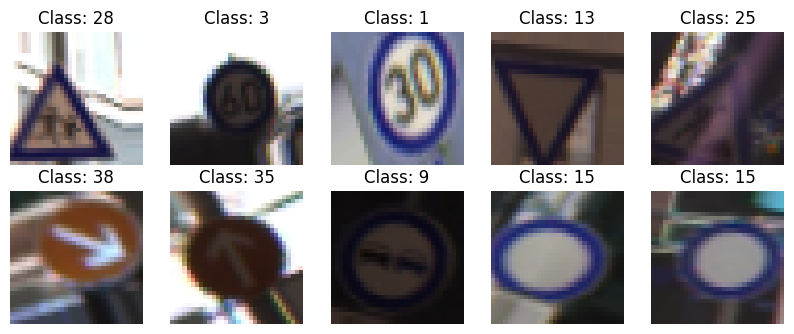

In [5]:
import matplotlib.pyplot as plt

# Visualize some augmented images
augmented_images, augmented_labels = next(train_generator)

# Plot some examples
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f'Class: {np.argmax(augmented_labels[i])}')
    plt.axis('off')
plt.show()

In [6]:
# Load the test dataset
def load_test_data(test_dir):
    images = []
    img_names = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)

        # Check if the file is an image
        _, file_extension = os.path.splitext(img_file)
        if file_extension.lower() not in valid_extensions:
            print(f"Skipping non-image file: {img_file}")
            continue  # Skip non-image files

        # Read and resize the image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        # Append the image and image file name to the lists
        images.append(image)
        img_names.append(img_file)

    # Convert images to a NumPy array
    images = np.array(images, dtype='float32')
    return images, img_names

# Load test images
X_test, test_img_names = load_test_data(test_dir)

# Normalize pixel values (same as training data)
X_test = X_test.astype('float32') / 255.0

Skipping non-image file: GT-final_test.test.csv


##Load vgg16

In [7]:
# Here is where you can import a pre-trained model, for this case we can use VGG16, but try others!
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers[:11]:
    layer.trainable = False

# Here we can add our base model to our own.
model = models.Sequential()

# Add the pre-trained base model
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('block5_pool').output
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
out = layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
model = models.Model(inputs = base_model.input, outputs = out, name='model')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the augmented data generator
history = model.fit(train_generator, epochs=5, steps_per_epoch=len(X_train) // 32, callbacks=[early_stopping])

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1225/1225 ━━━━━━━━━━━━━━━━━━━━ 56s 38ms/step - accuracy: 0.1332 - loss: 3.2230
Epoch 2/5
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.4688 - loss: 1.6098 
Epoch 3/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1225/1225 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0.4519 - loss: 1.7160
Epoch 4/5
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 0s 39us/step - accuracy: 0.6250 - loss: 1.4751 
Epoch 5/5
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 81s 35ms/step - accuracy: 0.5520 - loss: 1.3725


In [9]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Create a DataFrame to save the image file names and predicted classes
result_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
result_df = result_df.sort_values(by='Filename')

# Save the results to a CSV file
result_df.to_csv('gtsrb_test_predictions.csv', index=False)
print("Predictions saved to 'gtsrb_test_predictions.csv'")

# Load your predictions
predictions_df = pd.read_csv('gtsrb_test_predictions.csv')

# Load the ground truth file (downloaded separately)
ground_truth_df = pd.read_csv('/content/drive/My Drive/Data/GTSRB/GT-final_test.csv', sep=';')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth_df[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Test Accuracy: {accuracy * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
Predictions saved to 'gtsrb_test_predictions.csv'
Test Accuracy: 60.21%


## Evaluate on Validation data

In [10]:
# Evaluate on Validation data
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f'Test accuracy: {test_acc}')

# Get model predictions
y_pred = model.predict(X_val)  #predictions
y_pred_classes = np.argmax(y_pred, axis=1) #predicted_classes
y_true = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

NameError: name 'X_val' is not defined

##Evaluate on test data

In [ ]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

In [ ]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

##Save the result

In [ ]:
# Create a DataFrame to save the image file names and predicted classes
result_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
result_df = result_df.sort_values(by='Filename')

# Save the results to a CSV file
result_df.to_csv('gtsrb_test_predictions.csv', index=False)
print("Predictions saved to 'gtsrb_test_predictions.csv'")

In [ ]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Create a DataFrame to save the image file names and predicted classes
result_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
result_df = result_df.sort_values(by='Filename')

# Save the results to a CSV file
result_df.to_csv('gtsrb_test_predictions.csv', index=False)
print("Predictions saved to 'gtsrb_test_predictions.csv'")

# Load your predictions
predictions_df = pd.read_csv('gtsrb_test_predictions.csv')

# Load the ground truth file (downloaded separately)
ground_truth_df = pd.read_csv('/content/drive/My Drive/Data/GTSRB/GT-final_test.csv', sep=';')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth_df[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Load your predictions
predictions_df = pd.read_csv('gtsrb_test_predictions.csv')
predictions_df.head()

In [ ]:
predicted_classes = predictions_df['Predicted Class'].unique()
print(len(predicted_classes))

In [ ]:
import pandas as pd

# Load your predictions
predictions_df = pd.read_csv('gtsrb_test_predictions.csv')

# Load the ground truth file (downloaded separately)
ground_truth_df = pd.read_csv('/content/drive/My Drive/Data/GTSRB/GT-final_test.csv', sep=';')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth_df[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Test Accuracy: {accuracy * 100:.2f}%")
